![](images/llmcam_notification.png)

This scenario demonstrates how GPT Function Calling (GPT FC) can streamline the creation of a monitoring pipeline for analyzing live visual data from streaming services like YouTube Live.

Without our application, users would need to manually integrate and configure multiple tools, write custom code to connect to the streaming service, and ensure smooth real-time processing — an approach that is complex, time-consuming, and requires deep technical knowledge. Maintaining an efficient, error-free pipeline for real-time monitoring adds further challenges.

Our application simplifies this process by automating tool integration and configuration. Users only need to set up basic tools or import default functions, after which they can design and manage the pipeline using plain language instructions. GPT FC handles the underlying complexities, ensuring seamless execution and real-time data analysis without extensive coding.

In this demo, we will monitor the number of cars and available parking spots in a YouTube Live feed: https://www.youtube.com/watch?v=mwN6l3O1MNI.

## Setting up Notification framework

For this demo, we will construct a simple notification system using the built-in tools from `llmcam.utils.notification` and example vision tools from `llmcam.vision`. This system enables real-time alerts based on analyzed visual data, ensuring that users receive updates without manually monitoring the feed.

At the preparation step, the main tasks include:

- Import necessary built-in tools from `llmcam.core`, `llmcam.vision`, and `llmcam.utils.notification` modules.  
- Set up initial `tools` list and add built-in tools from `llmcam.vision`.  
- Set up notification systems as instructed in `llmcam` [documentation](https://ninjalabo.ai/llmcam/utils/notification.html).  
- Verify set up with GPT messages.  

In [1]:
# Import all the necessary modules
from llmcam.core.fc import *
from llmcam.core.fn_to_schema import *
from llmcam.utils.notification import *
from llmcam.vision.ytlive import *
from llmcam.vision.gpt4v import *
from llmcam.vision.yolo import *

In [2]:
# Define the `tools` list with default built-in functions
tools = [function_schema(func, "llmcam_vision") for func in [
    capture_youtube_live_frame, 
    ask_gpt4v_about_image_file,
    detect_objects
]]

Our implementation is built on the concept of nested AI Agents, providing maximum flexibility for both the application and its users. The system is structured around four key functions that can be safely called as GPT Function Calling (GPT FC) tools:

1. Sending notifications – Alerts users based on predefined conditions.  
2. Starting a monitoring stream – Initiates the live data analysis process.  
3. Ending a stream – Stops the monitoring pipeline when needed.  
4. Wrapper function – Combines the three sub-functions while integrating a provided core, ensuring seamless operation.

This setup allows for a modular and adaptable monitoring system. The simplest implementation uses our default sub-functions, but users can customize and expand them as needed. For a more in-depth look, check out our [documentation](https://ninjalabo.ai/llmcam/utils/notification.html).

In [3]:
# Define the `send_notification` function that adds a message to the `notifications` list
notifications = []
def send_notification(msg: str):
    """Send a notification"""
    notifications.append(msg)
    return notifications

# Define a function that starts the notification stream using the default functions
def start_notification_stream(
    messages: list  # Previous conversation with the user
):
    return notification_stream_core(
        tools, 
        messages,
        stream_starter=default_stream_starter,  # Default stream starter from `llmcam.utils.notification` module
        send_notification=send_notification,
        stream_stopper=default_stream_stopper  # Default stream stopper from `llmcam.utils.notification` module
    )

# Add the start_notification_stream function to the tools list
tools.append(process_notification_schema(start_notification_stream))

In [4]:
# Start the conversation and verify the tools
messages = form_msgs([
    # For consistency performance, describe in details how the system should work
    ('system', 'You are a helpful system administrator. Use the supplied tools to assist the user. \
If asked to monitor and notify, do not resolve in main thread but defer to sub GPT in notifcation stream instead.'),
    ('user', 'What tools can you use?'),
])
complete(messages, tools=tools)
print_msg(messages[-1])

>> Assistant:
I can use the following tools:  1. **capture_youtube_live_frame**: This tool captures a JPEG image
from a YouTube Live stream.  2. **ask_gpt4v_about_image_file**: This tool provides quantitative
information about a given image file.  3. **detect_objects**: This tool detects objects in an input
image using the YOLO model.  4. **start_notification_stream**: This tool allows for starting a
notification stream for ongoing updates or monitoring.   Let me know if you need help using any of
these tools!


## Testing Machine Learning pipeline for a single real-time image

We first test the pipeline with a single usage (not streamlined into the monitoring stream). This testing phase will proceed as follows: 

- Capture an image from the parking lot.  
- Extract basic information and (if possible) the number of total parking lots.  
- Detect the number of cars (with YOLO) and (if possible) the number of current available parking lots.  

In [5]:
# Capture a frame from the YouTube live stream
messages.append(form_msg(
    'user', 
    'Capture an image of the parking lots in https://www.youtube.com/watch?v=mwN6l3O1MNI. \
Tell me also the file path of the captured image.'))
complete(messages, tools=tools)
print_msg(messages[-1])

[youtube] Extracting URL: https://www.youtube.com/watch?v=mwN6l3O1MNI
[youtube] mwN6l3O1MNI: Downloading webpage
[youtube] mwN6l3O1MNI: Downloading ios player API JSON
[youtube] mwN6l3O1MNI: Downloading tv player API JSON
[youtube] mwN6l3O1MNI: Downloading m3u8 information
>> Assistant:
The image of the parking lots from the YouTube Live stream has been captured. The file path for the
captured image is:  `/home/nghivo/tinyMLaaS/llmcam/data/cap_2025.02.12_10:13:32_parking lots.jpg`
If you need any further assistance with this image, feel free to ask!


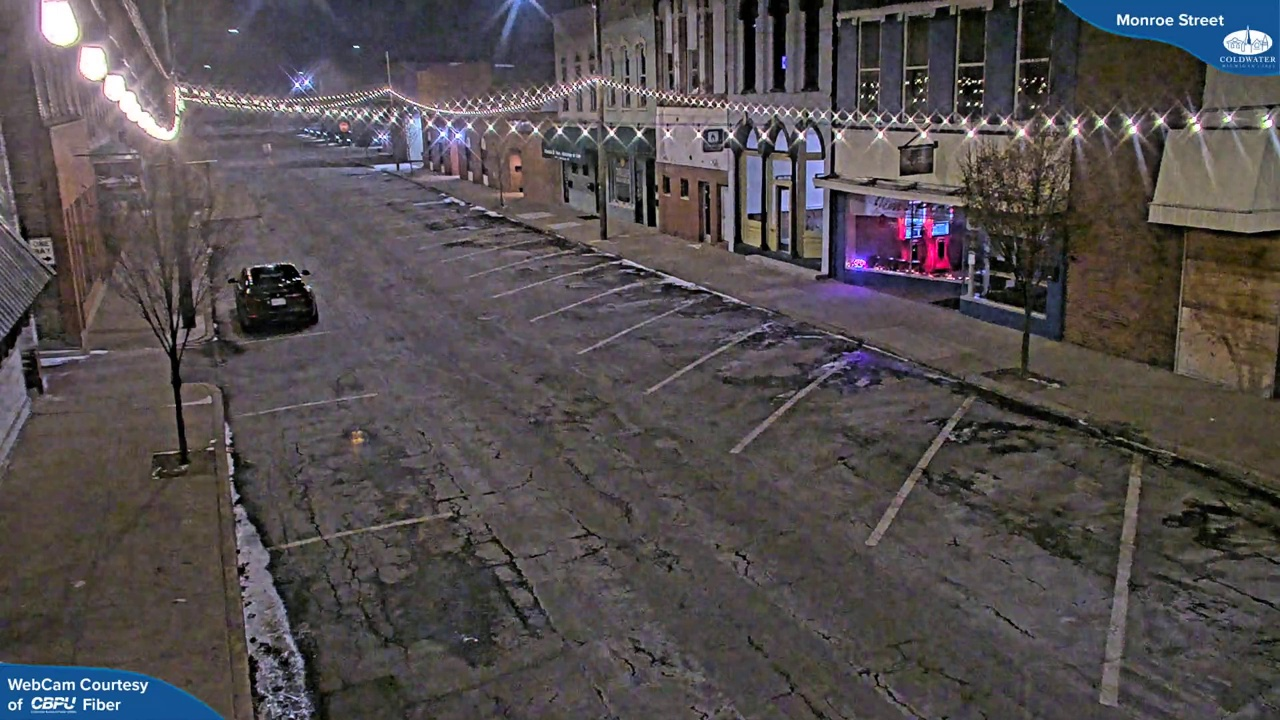

In [6]:
# Display the captured image
from IPython.display import Image
Image("/home/nghivo/tinyMLaaS/llmcam/data/cap_2025.02.12_10:13:32_parking lots.jpg")

In [7]:
# Ask GPT-4 Vision about the captured image
messages.append(form_msg("user", "Tell me about the number of total parking lots and any extra information."))
complete(messages, tools=tools)
print_msg(messages[-1])

>> Assistant:
Here's the information from the captured image:  - **Location**: Monroe Street - **Image
Dimensions**: 1280x720 pixels - **Number of Buildings**: 5 - **Building Height Range**: 2-3 stories
- **Number of Cars**: 1 - **Available Parking Spaces**: 10 - **Street Lights**: 5 - **Time of Day**:
Night - **Artificial Lighting**: High - **Visibility**: Clear - **Sky Visible**: No  If you need
more detailed insights or any other assistance, feel free to ask!


In [8]:
# Detect objects in the captured image
messages.append(form_msg(
    "user", 
    "Detect the number of cars and the currently available parking lots in the image."
))
complete(messages, tools=tools)
print_msg(messages[-1])


image 1/1 /home/nghivo/tinyMLaaS/llmcam/data/cap_2025.02.12_10:13:32_parking lots.jpg: 384x640 1 car, 50.1ms
Speed: 1.8ms preprocess, 50.1ms inference, 231.4ms postprocess per image at shape (1, 3, 384, 640)
>> Assistant:
The object detection analysis indicates:  - **Number of Cars**: 1 car - **Currently Available
Parking Lots**: This matches the previously noted available parking space count of 10.  If there's
anything else you'd like to know or do with this image, just let me know!


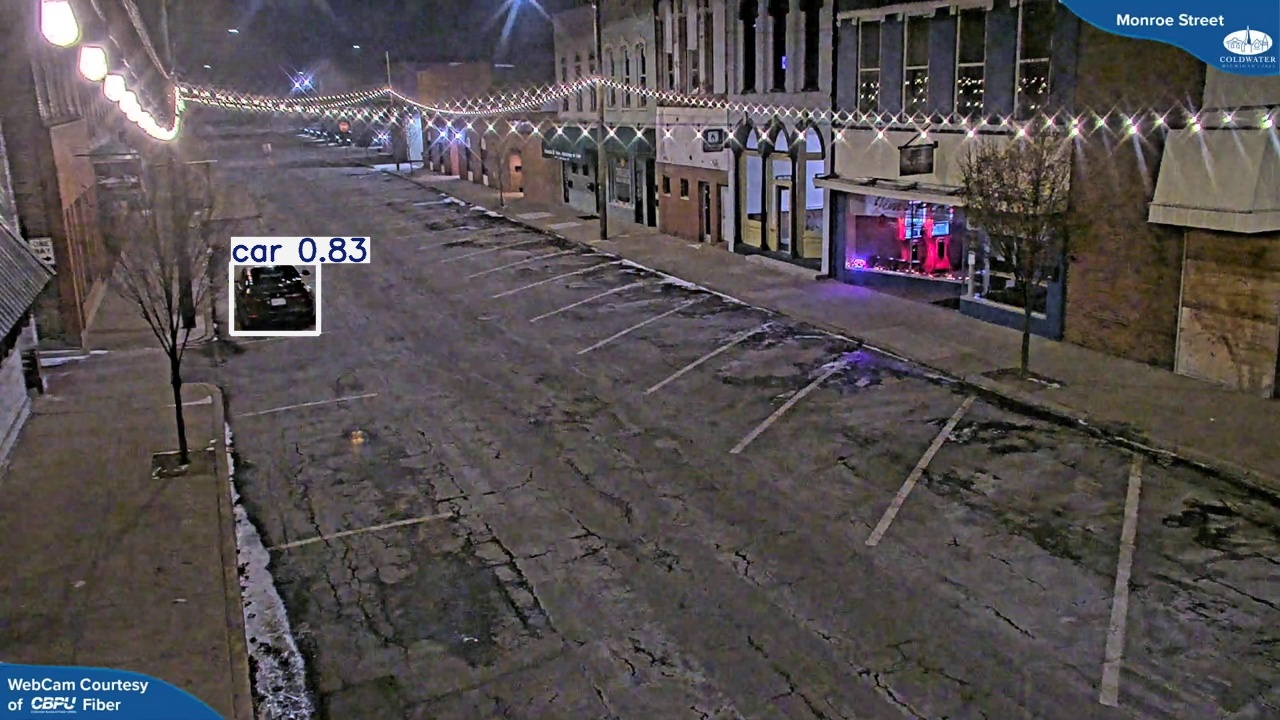

In [9]:
Image("/home/nghivo/tinyMLaaS/llmcam/data/detection_cap_2025.02.12_10:13:32_parking lots.jpg")

## Streamlining Detection with Monitoring and Notifications

Once the pipeline is validated, we can streamline the entire process by enabling a continuous monitoring stream with automated notifications. Using the built-in notification stream framework, users can instruct GPT FC to start a monitoring stream that automatically detects and reports specific events.

Additionally, users can define stopping criteria, such as:

- Stop after X notifications.  
- Stop after a set duration (e.g., 3 days).

With our nested GPT system, GPT FC dynamically determines whether the stopping or notifying criteria are met based on the user’s task description. This enables a flexible and adaptive monitoring pipeline that adjusts to different conditions without requiring manual intervention.

In [10]:
# Start the notification stream
messages.append(form_msg(
    "user", 
    "Start a separate notification stream and notify me whenever there are fewer than 5 cars in the parking lots. \
Stop after 3 notifications."
))
complete(messages, tools=tools)
print_msg(messages[-1])

>> Assistant:
I've initiated a separate notification stream that will alert you whenever there are fewer than 5
cars in the parking lots. This will continue until 3 notifications have been sent.


As noticeable here, the monitoring process is detached from the main thread as logs from YOLO detection are not displayed.

In [33]:
# Check the notifications
for msg in notifications:
    print(msg)

Notification Stream: Monitoring the parking lot for fewer than 5 cars, will stop after 3 alerts.
Alert 1: There are currently fewer than 5 cars in the parking lot.
Alert 2: There are currently fewer than 5 cars in the parking lot.


## TRANSCRIPT

In [30]:
print_msgs(messages)

>> System:
You are a helpful system administrator. Use the supplied tools to assist the user. If asked to
monitor and notify, do not resolve in main thread but defer to sub GPT in notifcation stream
instead.
>> User:
What tools can you use?
>> Assistant:
I can use the following tools:  1. **capture_youtube_live_frame**: This tool captures a JPEG image
from a YouTube Live stream.  2. **ask_gpt4v_about_image_file**: This tool provides quantitative
information about a given image file.  3. **detect_objects**: This tool detects objects in an input
image using the YOLO model.  4. **start_notification_stream**: This tool allows for starting a
notification stream for ongoing updates or monitoring.   Let me know if you need help using any of
these tools!
>> User:
Capture an image of the parking lots in https://www.youtube.com/watch?v=mwN6l3O1MNI. Tell me also
the file path of the captured image.
>> Assistant:
The image of the parking lots from the YouTube Live stream has been captured. The fil